In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import os
import sys
%env QPROF_DATA_PATH=/home/simonpf/src/qprof/data
sys.path.append("/home/simonpf/src/qprof")

env: QPROF_DATA_PATH=/home/simonpf/src/qprof/data


# Training data

The interface to the training data is realized using pytorchs Dataset
class. The data object provides access to single samples in the training
data.

In [3]:
from qprof.data import RainRates
qprof_path = os.environ["QPROF_DATA_PATH"]
path = os.path.join(qprof_path, "training_data_full.nc")
data = RainRates(path, batch_size = 256)

For the actual training, the data object needs to be wrapped in a data loader, which generates batches
from the training data.

In [4]:
import torch
from torch.utils.data import DataLoader, random_split
n_train = int(0.90 * len(data))
n_val = len(data) - n_train
training_data, validation_data = random_split(data, [n_train, n_val])
training_loader = DataLoader(training_data, batch_size = None, shuffle = False)
validation_loader = DataLoader(validation_data, batch_size = None)

In [5]:
qprof_path

'/home/simonpf/src/qprof/data'

In [6]:
import torch.cuda
torch.cuda.init()
torch.cuda.is_available()

True

# QRNN training

Training the QRNN is straight forward.

In [35]:
from typhon.retrieval.qrnn.backends.pytorch import QRNN
quantiles = [0.01, 0.05, 0.15, 0.25, 0.35, 0.45, 0.5, 0.55, 0.65, 0.75, 0.85, 0.95, 0.99]
qrnn = QRNN(13, quantiles, depth = 10, width = 512)
qrnn.train(training_loader, validation_loader, adversarial_training = False, gpu = True, lr = 1e-3)
qrnn.train(training_loader, validation_loader, adversarial_training = False, gpu = True, lr = 1e-4)
qrnn.train(training_loader, validation_loader, adversarial_training = False, gpu = True, lr = 1e-5)
qrnn.train(training_loader, validation_loader, adversarial_training = False, gpu = True, lr = 1e-6)

In [46]:
qrnn.criterion.quantiles.dtype

torch.float32

# Evaluation

We briefly compute the calibration on the validation set.

In [32]:
import torch
from torch.utils.data import DataLoader, random_split
n_train = int(0.8 * len(data))
n_val = len(data) - n_train
training_data, validation_data = random_split(data, [n_train, n_val])
training_loader = DataLoader(training_data, batch_size = None)
validation_loader = DataLoader(validation_data, batch_size = None)

In [33]:
intervals, frequencies


(array([0.1 , 0.3 , 0.5 , 0.7 , 0.9 , 0.98]),
 array([0.        , 0.8452369 , 0.8452369 , 0.8562627 , 0.94475904,
        0.98959667]))

In [36]:
intervals, frequencies = qrnn.calibration(validation_loader)

<module 'matplotlib.pyplot' from '/home/simonpf/build/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

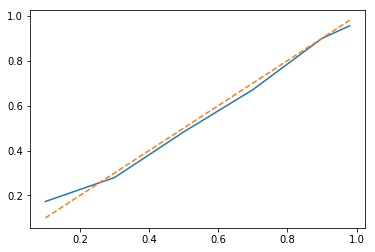

In [37]:
plt.plot(intervals, frequencies)
plt.plot(intervals, intervals, ls = "--")
plt

In [56]:
from typhon.retrieval.qrnn.backends.pytorch import QuantileLoss

In [64]:
np.repeat

<function numpy.repeat(a, repeats, axis=None)>

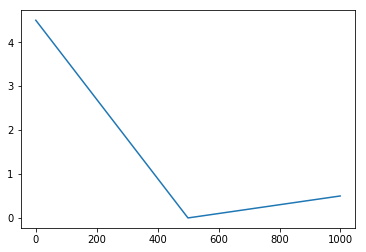

In [81]:
import numpy as np
ql = QuantileLoss([0.9])
y = torch.tensor(np.zeros((1, 1))).float()
y_pred = torch.tensor(np.repeat(np.linspace(-5, 5, 101).reshape(-1, 1), 1, axis = 1)).float()

ls = np.zeros(1000)
x = np.linspace(-5, 5, 1000)
for i in range(1000):
    y_pred = torch.tensor([x[i]])
    ls[i] = ql(y_pred, y)
plt.plot(ls)

tensor([[-5.0000, -5.0000, -5.0000, -5.0000, -5.0000],
        [-4.9000, -4.9000, -4.9000, -4.9000, -4.9000],
        [-4.8000, -4.8000, -4.8000, -4.8000, -4.8000],
        [-4.7000, -4.7000, -4.7000, -4.7000, -4.7000],
        [-4.6000, -4.6000, -4.6000, -4.6000, -4.6000],
        [-4.5000, -4.5000, -4.5000, -4.5000, -4.5000],
        [-4.4000, -4.4000, -4.4000, -4.4000, -4.4000],
        [-4.3000, -4.3000, -4.3000, -4.3000, -4.3000],
        [-4.2000, -4.2000, -4.2000, -4.2000, -4.2000],
        [-4.1000, -4.1000, -4.1000, -4.1000, -4.1000],
        [-4.0000, -4.0000, -4.0000, -4.0000, -4.0000],
        [-3.9000, -3.9000, -3.9000, -3.9000, -3.9000],
        [-3.8000, -3.8000, -3.8000, -3.8000, -3.8000],
        [-3.7000, -3.7000, -3.7000, -3.7000, -3.7000],
        [-3.6000, -3.6000, -3.6000, -3.6000, -3.6000],
        [-3.5000, -3.5000, -3.5000, -3.5000, -3.5000],
        [-3.4000, -3.4000, -3.4000, -3.4000, -3.4000],
        [-3.3000, -3.3000, -3.3000, -3.3000, -3.3000],
        [-